In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle

###load features

In [2]:
filename='data/small_enc_features.pkl'
with open(filename, 'rb') as handle:
    small_enc_features=pickle.load(handle)
filename='data/enc_features.pkl'
with open(filename, 'rb') as handle:
    enc_features=pickle.load(handle)
filename='data/pca1800_features.pkl'
with open(filename, 'rb') as handle:
    pca_features=pickle.load(handle)

filename='data/NZ_del20.pkl' #deleted 20% images with lower NZ count
with open(filename, 'rb') as handle:
    subset_dict=pickle.load(handle)
GO_terms=subset_dict['GO_terms']
gene_id=subset_dict['gene_id']
del subset_dict


##look if same gene id gives higher similarity

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
enc_sim=cosine_similarity(enc_features)
small_sim=cosine_similarity(small_enc_features)
pca_sim=cosine_similarity(pca_features)
del pca_features, enc_features, small_enc_features

In [4]:
sim_pairs=[]
sim_dif=[]
for i in range(10000):
    for j in range(i):
        if gene_id[i]==gene_id[j]:
            sim_pairs.append([enc_sim[i,j],small_sim[i,j],pca_sim[i,j]])
        else:
            sim_dif.append([enc_sim[i,j],small_sim[i,j],pca_sim[i,j]])
    if i%1000==0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [6]:
sim_pairs=np.asarray(sim_pairs)
sim_dif=np.asarray(sim_dif)


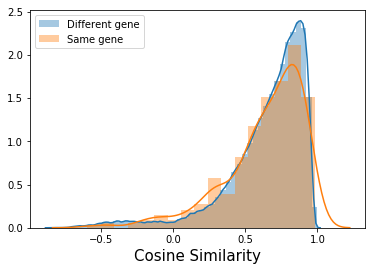

In [19]:
import seaborn as sns
sns.distplot(sim_dif[:,2]);
sns.distplot(sim_pairs[:,2]);
plt.legend(['Different gene', 'Same gene'])
plt.xlabel('Cosine Similarity', fontsize=15)
plt.savefig('pca_geneSim_cos.pdf')


###determine if GO categories result in more features similarity

In [3]:
'''
PICK THE GO TERMS THAT SHOW UP IN BETWEEN 15 and 500 Slices
'''
def get_15to500_GO(GO_terms):
    GO_annotations_nb = {}
    for GO_list in GO_terms:
        for GO_term in GO_list:
            if GO_term in GO_annotations_nb:
                GO_annotations_nb[GO_term] += 1
            else:
                GO_annotations_nb[GO_term] = 1

    list15to500GO = []
    list15to500values = []
    for GO in GO_annotations_nb.keys():
        if GO_annotations_nb[GO] >= 15 and GO_annotations_nb[GO] <= 500:
            list15to500GO.append(GO)
            list15to500values.append(GO_annotations_nb[GO])

    GO_list=[]
    for GO_term in list15to500GO:
        image_list=[]
        for image_GO in GO_terms:
            if GO_term in image_GO:
                image_list.append(1)
            else:
                image_list.append(0)
        GO_list.append(image_list)
    return np.asarray(GO_list), list15to500values, list15to500GO


In [4]:
[GO_term_array, list15to500values, list15to500GO]=get_15to500_GO(GO_terms)

In [ ]:
data=enc_features
same_GO_correlations=[]
dif_GO_correlations=[]
GO_sims=[]
for i in range(1,1000):
    for j in range(i):
        img_GO=GO_term_array[:,i]
        idx_1=(img_GO==1)
        img_GO=GO_term_array[:,j]
        idx_2=(img_GO==1)
        if np.sum(idx_1*idx_2)>15:
            continue
        else:
            a=data[i,:].reshape(-1)
            b=data[j,:].reshape(-1)
            dist=np.corrcoef(a,b)[0,1]
            dif_GO_correlations.append(dist)
    if i%100==0:
        print(i)
for i in range(1,10000):
    for j in range(i):
        #evaluating similarity based on proportion of GO annotations that are shared
        img_GO=GO_term_array[:,i]
        idx_1=(img_GO==1)
        img_GO=GO_term_array[:,j]
        idx_2=(img_GO==1)
        if np.sum(idx_1*idx_2)>15:
            GO_sim=np.sum(idx_1*idx_2)/(np.sum(idx_1)+np.sum(idx_2))
            GO_sims.append(GO_sim)
            a=data[i,:].reshape(-1)
            b=data[j,:].reshape(-1)
            dist=np.corrcoef(a,b)[0,1]
            same_GO_correlations.append(dist)
        else:
            continue
GO_sims=np.asarray(GO_sims)
same_GO_correlations=np.asarray(same_GO_correlations)
dif_GO_correlations=np.asarray(dif_GO_correlations)


In [ ]:
import seaborn as sns
sns.distplot(same_GO_correlations);
sns.distplot(dif_GO_correlations);
plt.legend(['At least 15 GO in common', 'Less than 15 common GO'])
#plt.savefig('enc_GOSim_corr.pdf')
print(same_GO_correlations.mean())
print(dif_GO_correlations.mean())


####Analyze results from random search and from all GO term classification by the autoencoder

In [81]:
#make a list of 100 random GO index
length=GO_term_array.shape[0]
import random
idx_list=random.sample(range(0, length), 100)

import csv

csvfile='random_GO_idx.csv'
#Assuming res is a flat list
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in idx_list:
        writer.writerow([val])

In [29]:
#load the results from randomized search
files=os.listdir('data/rs/')
rs_GO_list=[]
for file in files:
    filename='data/rs/%s' % (str(file))
    try:
        with open(filename, 'rb') as handle:
            data=pickle.load(handle)
        rs_GO_list.append(data)
    except:
        continue

rs_data=[]
for data in rs_GO_list:
    dictlist=[]
    for key, value in data.items():
        temp = value
        dictlist.append(temp)
    rs_data.append(dictlist)
rs_data=np.asarray(rs_data)

concat_rs=[]
for key in range(rs_data.shape[1]):
    concat_rs.append(rs_data[:,key,:].reshape(-1))
    

In [30]:
#print the mean performances for different hyperparameters
penalties=['l1', 'l2']
reg_params=[0.001,0.01,0.1,1,10]
for reg_param in reg_params:
    for penalty in penalties:
        idx=np.where(((concat_rs[0]==reg_param) * (concat_rs[1]==penalty)))
        import seaborn as sns
#        plt.figure()
#        sns.distplot(list(concat_rs[2][idx]));
        print(penalty+' '+str(reg_param)+' '+str(concat_rs[2][idx].mean())+' '+str(concat_rs[2][idx].std()))
        print(str(concat_rs[2][idx].max()))


l1 0.001 0.5561935796606968 0.09254783855640956
0.8194266071370211
l2 0.001 0.5682266522377498 0.0910417356651619
0.844867499823186
l1 0.01 0.5626945464256464 0.09066446620774585
0.895433501260899
l2 0.01 0.5683807250857555 0.09225121676730236
0.8536930020630301
l1 0.1 0.5691369632183534 0.09139151042565183
0.8953912320701004
l2 0.1 0.5660918014190789 0.09021964874821306
0.8286624956647702
l1 1 0.5684379548274959 0.09283891602754797
0.883373214762536
l2 1 0.565189807343464 0.0897584176322301
0.8090099851113363
l1 10 0.5678101418116271 0.0924969492446716
0.8758759732948829
l2 10 0.5651711572113235 0.08965283633866132
0.8113035803151425


In [43]:
#make a list of chunks of 10 GO index to run in parallel
length=GO_term_array.shape[0]
chunk_list=[]
for i in range(0,length, 10):
    if i+10>length:
        chunk_list.append(np.arange(i, length))
        break
    chunk_list.append(np.arange(i, i+10))


In [45]:
#make a list of chunks of 10 GO index to run in parallel
length=GO_term_array.shape[0]
chunk_list=[]
for i in range(0,length, 10):
    if i+10>length:
        chunk_list.append(np.arange(i, length))
        break
    chunk_list.append(np.arange(i, i+10))

filename='GO_chunk.pkl'
with open(filename, 'wb') as handle:
    pickle.dump(chunk_list, handle)

idx_list=np.arange(0,len(chunk_list))

import csv
csvfile='chunk_GO_idx.csv'
#Assuming res is a flat list
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in idx_list:
        writer.writerow([val])
        


In [13]:
#load the results from randomized search
files=os.listdir('data/pred/')
GO_scores=[]
for file in files:
    filename='data/pred/%s' % (str(file))
    with open(filename, 'rb') as handle:
        data=pickle.load(handle)
    GO_scores.append(data)

scores=[]
GO=[]
GO_count=[]
for i in GO_scores:
    for j in i:
        scores.append(j[0]['mean_test_score'][0])
        GO_count.append(j[1])
        GO.append(j[2])
GO=np.asarray(GO)
GO_count=np.asarray(GO_count)
scores=np.asarray(scores)


In [14]:
best_idx=np.argsort(scores)[-15:]
best_scores=[scores[best_idx], GO[best_idx], GO_count[best_idx]]
print(best_scores[0])
print(best_scores[1])
print(best_scores[2])


[0.88814996 0.89278346 0.8966949  0.90602464 0.90677096 0.91018451
 0.91318938 0.93917122 0.95127254 0.95388063 0.96453151 0.98006667
 0.99402223 0.99402223 0.99402223]
['GO:0005499' 'GO:0006491' 'GO:0004571' 'GO:0061564' 'GO:0072205'
 'GO:1900271' 'GO:0098688' 'GO:0043292' 'GO:0004351' 'GO:0099509'
 'GO:0072221' 'GO:0099534' 'GO:0099567' 'GO:0035502' 'GO:0072286']
[20 27 24 25 19 26 32 24 19 21 18 33 17 17 17]


In [15]:
enc_scores=scores

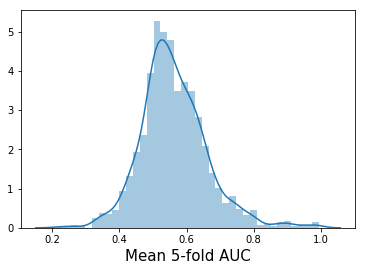

In [28]:
#
import seaborn as sns
sns.distplot(scores);
plt.xlabel('Mean 5-fold AUC', fontsize=15)
plt.savefig('allGO_enc_AUC.pdf')

###SIFT predictions across GO terms

In [60]:
#load the results from randomized search
files=os.listdir('sift_data/pred/')
GO_scores=[]
for file in files:
    filename='sift_data/pred/%s' % (str(file))
    with open(filename, 'rb') as handle:
        data=pickle.load(handle)
    GO_scores.append(data)

scores=[]
GO=[]
for i in GO_scores:
    for j in i:
        scores.append(j[0]['mean_test_score'][0])
        GO.append(j[1])
GO=np.asarray(GO)
scores=np.asarray(scores)


In [61]:
best_idx=np.argsort(scores)[-15:]
best_scores=[scores[best_idx], GO[best_idx]]
print(best_scores[0])
print(best_scores[1])


[0.69105008 0.69713801 0.70154924 0.70402474 0.7121028  0.71365773
 0.71369075 0.71405954 0.7279863  0.73584217 0.73750075 0.75275255
 0.75430018 0.7863646  0.79827359]
['GO:0004950' 'GO:0070328' 'GO:0005550' 'GO:0045907' 'GO:0019236'
 'GO:0045109' 'GO:0044306' 'GO:0010951' 'GO:0043029' 'GO:0005549'
 'GO:0007608' 'GO:0004984' 'GO:0007614' 'GO:0050909' 'GO:0043292']


In [12]:
sift_scores=scores

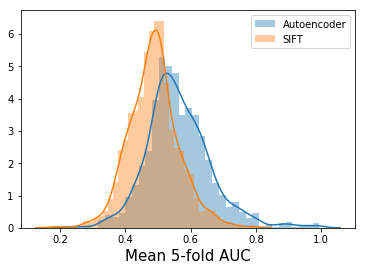

In [17]:
#
import seaborn as sns
sns.distplot(enc_scores);
sns.distplot(sift_scores);
plt.xlabel('Mean 5-fold AUC', fontsize=15)
plt.legend(['Autoencoder', 'SIFT'])
plt.savefig('allGO_both_AUC.pdf')

####PREDICTIONS ON TOP 15 GO TERMS

In [49]:
#load the results from randomized search
files=os.listdir('data/pred/')
GO_scores=[]
for file in files:
    filename='data/pred/%s' % (str(file))
    with open(filename, 'rb') as handle:
        data=pickle.load(handle)
    GO_scores.append(data)

scores=[]
GO=[]
GO_count=[]
for i in GO_scores:
    for j in i:
        scores.append(j[0]['mean_test_score'][0])
        GO_count.append(j[1])
        GO.append(j[2])
GO=np.asarray(GO)
GO_count=np.asarray(GO_count)
scores=np.asarray(scores)

idx=np.argsort(scores)[-15:]


In [50]:
list15to500GO=np.asarray(list15to500GO)
top_GO=np.asarray(GO)[idx]
idx_list=[]
for GO in top_GO:
    i=0
    for list_GO in list15to500GO:
        if list_GO==GO:
            idx_list.append(i)
        i+=1

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC

pipe_LinearSVC = Pipeline([
    ('clf', LinearSVC(penalty='l1', dual=False, C=0.1, class_weight="balanced", max_iter=1000, random_state=0)),
])

'''
Searching for hyperparameters with Randomized search
'''

params = {"clf__penalty": ['l1'],
          "clf__C": [0.1]} 

seed = 551 # Setting a constant seed for repeatability.
num_iter=1
cv=5 #number of cross-validation folds
pipe=pipe_LinearSVC 

X=enc_features
scores=[]
for i in idx_list:
    Y=GO_term_array[i,:]
    random_search = RandomizedSearchCV(pipe, param_distributions = params, scoring='roc_auc',cv=cv, verbose = 10, random_state = seed, n_iter = num_iter)
    random_search.fit(X, Y)

    #getting cross validation results
    results=random_search.cv_results_
    data = {"mean_test_score": list(results.get('mean_test_score').data),}

    print(data["mean_test_score"])
    scores.append([data, list15to500values[i], list15to500GO[i]])


In [39]:
filename='data/enc_scores.pkl'
with open(filename, 'wb') as handle:
    pickle.dump(scores, handle)
    

In [56]:
filename='data/enc_scores.pkl'
with open(filename, 'rb') as handle:
    enc_scores=pickle.load(handle)
filename='data/small_enc_scores.pkl'
with open(filename, 'rb') as handle:
    small_enc_scores=pickle.load(handle)
filename='data/pca_scores.pkl'
with open(filename, 'rb') as handle:
    pca_scores=pickle.load(handle)


In [68]:
sift_best=best_scores
final_scores=[]
for i in range(15):
    final_scores.append([enc_scores[i][2], enc_scores[i][0]['mean_test_score'][0], small_enc_scores[i][0]['mean_test_score'][0], pca_scores[i][0]['mean_test_score'][0], sift_best[1][i], sift_best[0][i]])
                        

In [74]:
columns=['Autoencoder Top 15 GO', 'Autoencoder Score', 'Small Autoencoder Score', 'PCA Score', 'SIFT Top 15 GO', 'SIFT Score']
df=pd.DataFrame(final_scores, columns=columns)

df.to_csv('final_scores.csv')